## 1. Importar Bibliotecas e Carregar Dataset Preprocessado

In [35]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import json
import pickle
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, roc_curve)
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, randint
from joblib import dump, load
import warnings
warnings.filterwarnings('ignore')

# Configurações de plotagem
plt.rcParams['figure.figsize'] = [12, 8]
sns.set_style("whitegrid")

print("Bibliotecas importadas com sucesso!")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")

Bibliotecas importadas com sucesso!
Pandas: 2.3.2
NumPy: 2.3.3
Scikit-learn: 1.7.2


In [36]:
# Carregamento e preparação inicial dos dados
print("Carregando datasets...")

# Carregar datasets pré-processados
train_data = pd.read_csv('dataset_sepsis_prepared.csv')
test_data = pd.read_csv('dataset_sepsis_test_prepared.csv')

print(f"Dataset de treino: {train_data.shape}")
print(f"Dataset de teste: {test_data.shape}")

# Separar features e target
X_train = train_data.drop('SepsisLabel', axis=1)
y_train = train_data['SepsisLabel']
X_test = test_data.drop('SepsisLabel', axis=1)
y_test = test_data['SepsisLabel']

# Normalização dos dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nDistribuição das classes:")
print("Treino:", y_train.value_counts().to_dict())
print("Teste:", y_test.value_counts().to_dict())

Carregando datasets...
Dataset de treino: (853006, 19)
Dataset de teste: (215171, 19)

Distribuição das classes:
Treino: {0.0: 831112, 1.0: 21894}
Teste: {0.0: 209675, 1.0: 5496}


## 2. Sampling para Busca de Hiperparâmetros

In [37]:
# ======================================================================
# SAMPLING ESTRATIFICADO PARA BUSCA DE HIPERPARÂMETROS
# ======================================================================

print("=== PREPARAÇÃO DE AMOSTRA PARA BUSCA DE HIPERPARÂMETROS ===")

# Dataset completo é muito grande (>1M instâncias) para busca de hiperparâmetros
# Vamos usar uma amostra estratificada de 4% para otimização

# Amostra estratificada do dataset de treino
_, X_sample, _, y_sample = train_test_split(
    X_train_scaled, y_train, 
    test_size=0.01,  
    stratify=y_train,
    random_state=10
)

print(f"Dataset original de treino: {X_train_scaled.shape[0]:,} amostras")
print(f"Amostra para busca de hiperparâmetros: {X_sample.shape[0]:,} amostras")
print(f"Redução: {(1 - X_sample.shape[0]/X_train_scaled.shape[0])*100:.1f}%")

print("\nDistribuição das classes na amostra:")
print("Amostra:", pd.Series(y_sample).value_counts().to_dict())
print("Original:", y_train.value_counts().to_dict())

=== PREPARAÇÃO DE AMOSTRA PARA BUSCA DE HIPERPARÂMETROS ===
Dataset original de treino: 853,006 amostras
Amostra para busca de hiperparâmetros: 8,531 amostras
Redução: 99.0%

Distribuição das classes na amostra:
Amostra: {0.0: 8312, 1.0: 219}
Original: {0.0: 831112, 1.0: 21894}


## 3. Funções Auxiliares

In [38]:
# Função auxiliar para cálculo do G-Mean
def gmean_score(y_true, y_pred):
    """Calcula o G-Mean (Geometric Mean) para problemas binários"""
    # Sensitivity (recall da classe positiva - sepsis)
    sensitivity = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    # Specificity (recall da classe negativa - sem sepsis)
    specificity = recall_score(y_true, y_pred, pos_label=0, zero_division=0)
    # G-Mean é a média geométrica de sensitivity e specificity
    return np.sqrt(sensitivity * specificity)

# Função para avaliar modelos
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Avalia um modelo treinado e retorna métricas completas"""
    # Predições
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Métricas de treino
    train_metrics = {
        'accuracy': accuracy_score(y_train, y_train_pred),
        'precision': precision_score(y_train, y_train_pred, zero_division=0),
        'recall': recall_score(y_train, y_train_pred, zero_division=0),
        'f1': f1_score(y_train, y_train_pred, zero_division=0),
        'gmean': gmean_score(y_train, y_train_pred)
    }
    
    # Métricas de teste
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred, zero_division=0),
        'recall': recall_score(y_test, y_test_pred, zero_division=0),
        'f1': f1_score(y_test, y_test_pred, zero_division=0),
        'gmean': gmean_score(y_test, y_test_pred)
    }
    
    # AUC-ROC para problemas binários
    try:
        y_test_proba = model.predict_proba(X_test)[:, 1]  # Probabilidade da classe positiva
        test_metrics['auc_roc'] = roc_auc_score(y_test, y_test_proba)
        
        # AUC-ROC para treino também
        y_train_proba = model.predict_proba(X_train)[:, 1]
        train_metrics['auc_roc'] = roc_auc_score(y_train, y_train_proba)
    except Exception as e:
        test_metrics['auc_roc'] = None
        train_metrics['auc_roc'] = None
    
    return train_metrics, test_metrics, y_test_pred

# Função para plotar histórico de busca
def plot_search_history(all_search_results, search_results, model_name, metric='mean_test_score'):
    """Plota a evolução dos resultados durante a busca de hiperparâmetros"""
        
    plt.figure(figsize=(15, 6))
        
    results_df = pd.DataFrame(search_results.cv_results_)
    # Extrair melhor score de cada busca
    search_scores = []
    search_indices = []
    
    for i, search_result in enumerate(all_search_results):
        search_scores.append(search_result['best_score'])
        search_indices.append(i + 1)
    
    plt.subplot(1, 2, 1)
    plt.plot(search_indices, search_scores, 'b-o', alpha=0.8, markersize=8)
    plt.title(f'{model_name} - Melhor F1-Score por Busca')
    plt.xlabel('Número da Busca')
    plt.ylabel('Melhor F1-Score')
    plt.grid(True, alpha=0.3)
    
    # Destacar a melhor busca
    best_idx = search_scores.index(max(search_scores))
    plt.plot(search_indices[best_idx], search_scores[best_idx], 'ro', markersize=12, 
            label=f'Melhor: {search_scores[best_idx]:.4f}')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    # Verificar se existe coluna de treino
    if 'mean_train_score' in results_df.columns:
        # Plotar treino com sombra
        plt.plot(results_df['mean_train_score'], 'g-o', alpha=0.7, label='Treino')
        plt.fill_between(range(len(results_df)), 
                        results_df['mean_train_score'] - results_df['std_train_score'],
                        results_df['mean_train_score'] + results_df['std_train_score'], 
                        color='green', alpha=0.2)
    
    # Plotar validação com sombra
    plt.plot(results_df[metric], 'b-o', alpha=0.7, label='Validação')
    plt.fill_between(range(len(results_df)), 
                    results_df[metric] - results_df['std_test_score'],
                    results_df[metric] + results_df['std_test_score'], 
                    color='blue', alpha=0.3)
    
    # DESTACAR A MELHOR ITERAÇÃO
    best_iteration_idx = results_df[metric].idxmax()
    best_iteration_score = results_df[metric].iloc[best_iteration_idx]
    
    plt.plot(best_iteration_idx, best_iteration_score, 'ro', markersize=15, 
            markeredgecolor='darkred', markeredgewidth=2,
            label=f'Melhor iteração: #{best_iteration_idx + 1} ({best_iteration_score:.4f})')
    
    plt.title(f'{model_name} - Treino vs Validação (Melhor Busca)')
    plt.xlabel('Iteração')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


def plot_search_history_from_loaded(loaded_results, model_name, metric='mean_test_score'):
    """Plota a evolução dos resultados a partir de loaded_results expandido."""

    detailed_df = loaded_results['detailed_df']

    plt.figure(figsize=(15, 6))

    # 1) Melhor score por busca (com desvio padrão) -----------------------
    best_per_search = detailed_df.loc[
        detailed_df.groupby('search_idx')[metric].idxmax()
    ]
    best_per_search = best_per_search[['search_idx', metric, 'std_test_score']].reset_index(drop=True)
    best_per_search['search_number'] = best_per_search['search_idx'] + 1  # 1-indexado

    plt.subplot(1, 2, 1)
    plt.plot(
        best_per_search['search_number'],
        best_per_search[metric],
        'b-o',
        alpha=0.8,
        markersize=8
    )

    # faixa do desvio padrão
    plt.fill_between(
        best_per_search['search_number'],
        best_per_search[metric] - best_per_search['std_test_score'],
        best_per_search[metric] + best_per_search['std_test_score'],
        color='blue',
        alpha=0.3
    )

    plt.title(f'{model_name} - Melhor score por busca (com desvio padrão)')
    plt.xlabel('Número da busca')
    plt.ylabel(metric)
    plt.grid(True, alpha=0.3)

    # destacar melhor busca
    best_search_idx = best_per_search[metric].idxmax()
    best_search_score = best_per_search[metric].iloc[best_search_idx]
    best_search_std = best_per_search['std_test_score'].iloc[best_search_idx]
    best_search_number = best_per_search['search_number'].iloc[best_search_idx]

    plt.plot(
        best_search_number,
        best_search_score,
        'ro',
        markersize=12,
        markeredgecolor='darkred',
        markeredgewidth=2,
        label=f'Melhor: {best_search_score:.4f} ± {best_search_std:.4f}'
    )
    plt.legend()

    # 2) Treino vs validação para a melhor busca --------------------------
    plt.subplot(1, 2, 2)

    # qual search_idx teve o melhor score geral
    best_overall_idx = detailed_df[metric].idxmax()
    best_overall_search_idx = int(detailed_df.loc[best_overall_idx, 'search_idx'])

    best_search_data = detailed_df[detailed_df['search_idx'] == best_overall_search_idx].copy()
    best_search_data = best_search_data.sort_values('iteration').reset_index(drop=True)
    iterations_1indexed = range(1, len(best_search_data) + 1)

    # treino
    if 'mean_train_score' in best_search_data.columns and best_search_data['mean_train_score'].notna().any():
        plt.plot(
            iterations_1indexed,
            best_search_data['mean_train_score'],
            'g-o',
            alpha=0.7,
            label='Treino'
        )

    # validação
    plt.plot(
        iterations_1indexed,
        best_search_data[metric],
        'b-o',
        alpha=0.7,
        label='Validação'
    )

    # destacar melhor iteração
    best_iteration_idx = best_search_data[metric].idxmax()
    best_iteration_score = best_search_data[metric].iloc[best_iteration_idx]
    best_iteration_number = best_search_data.index.get_loc(best_iteration_idx) + 1

    plt.plot(
        best_iteration_number,
        best_iteration_score,
        'ro',
        markersize=15,
        markeredgecolor='darkred',
        markeredgewidth=2,
        label=f'Melhor iteração: #{best_iteration_number} ({best_iteration_score:.4f})'
    )

    plt.title(f'{model_name} - Treino vs validação (melhor busca #{best_overall_search_idx + 1})')
    plt.xlabel('Iteração')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



# Função para executar múltiplas buscas de hiperparâmetros
def multiple_randomized_search(estimator, param_distributions, X, y, cv_strategy, 
                              n_searches=20, n_iter_per_search=80, scoring='f1', 
                              random_state=42, n_jobs=-1, verbose=0):
    """
    Executa múltiplas buscas RandomizedSearchCV e retorna a melhor configuração global
    
    Parameters:
    -----------
    n_searches : int
        Número de execuções do RandomizedSearchCV (default: 20)
    n_iter_per_search : int  
        Número de iterações por execução (default: 80)
    """
    print(f"Executando {n_searches} buscas com {n_iter_per_search} iterações cada...")
    
    best_overall_score = -np.inf
    best_overall_params = None
    best_search_result = None
    all_results = []
    
    for search_idx in range(n_searches):
        print(f"\nBusca {search_idx + 1}/{n_searches}...")
        
        # RandomizedSearchCV para esta execução
        search = RandomizedSearchCV(
            estimator=estimator,
            param_distributions=param_distributions,
            n_iter=n_iter_per_search,
            scoring=scoring,
            cv=cv_strategy,
            random_state=None,
            n_jobs=n_jobs,
            return_train_score=True,
            verbose=0  # Menos verbose para múltiplas execuções
        )
        
        search.fit(X, y)
        
        # Armazenar resultados desta busca
        search_results = {
            'search_idx': search_idx,
            'best_score': search.best_score_,
            'best_params': search.best_params_,
            'cv_results': search.cv_results_
        }
        all_results.append(search_results)
        
        # Verificar se esta é a melhor busca até agora
        if search.best_score_ > best_overall_score:
            best_overall_score = search.best_score_
            best_overall_params = search.best_params_
            best_search_result = search
            
        print(f"Melhor score desta busca: {search.best_score_:.4f}")
        print(f"Melhor configuração desta busca: {search.best_params_}")
        print(f"Melhor score geral até agora: {best_overall_score:.4f}")
    
    print(f"\n🎯 Busca completa! Melhor score geral: {best_overall_score:.4f}")
    print(f"Total de configurações testadas: {n_searches * n_iter_per_search:,}")
    
    return best_search_result, all_results, best_overall_params

print("Funções auxiliares definidas com sucesso!")

Funções auxiliares definidas com sucesso!


## 3.1 Definir Folds

In [39]:
# Configuração da validação cruzada estratificada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


## 4. KNN - Busca de Hiperparâmetros

In [ ]:
# Definir nome do modelo para uso em salvamento e exibição. Necessário Rodar essa célula antes de outras.
MODEL_NAME = "RF"

In [41]:
# ======================================================================
# 4.1 BUSCA DE HIPERPARAMETROS
# ======================================================================

print(f"=== BUSCA DE HIPERPARÂMETROS - {MODEL_NAME} ===")


# 4.3 Definição do Espaço de Hiperparâmetros
param_distributions = {
    'n_neighbors': randint(1, 100),           # Número de vizinhos
    'metric': ['euclidean', 'manhattan'],    # Métrica de distância
    'weights': ['uniform', 'distance'],      # Peso dos vizinhos
}

# 4.1 Múltiplas execuções do RandomizedSearchCV
print(f"Iniciando busca de hiperparâmetros para {MODEL_NAME}...")
model_search, model_all_searches, best_params = multiple_randomized_search(
    estimator=KNeighborsClassifier(),
    param_distributions=param_distributions,
    X=X_sample,                   
    y=y_sample,
    cv_strategy=cv_strategy,
    n_searches=20,                
    n_iter_per_search=40,        
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

# 5.1 Seleção da Melhor Configuração
print(f"\n--- RESULTADOS {MODEL_NAME} ---")
print("Melhores hiperparâmetros:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"\nMelhor F1-Score (CV): {model_search.best_score_:.4f}")

=== BUSCA DE HIPERPARÂMETROS - LVQ ===
Iniciando busca de hiperparâmetros para LVQ...
Executando 20 buscas com 40 iterações cada...

Busca 1/20...
Melhor score desta busca: 0.0654
Melhor configuração desta busca: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
Melhor score geral até agora: 0.0654

Busca 2/20...
Melhor score desta busca: 0.0333
Melhor configuração desta busca: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
Melhor score geral até agora: 0.0654

Busca 3/20...
Melhor score desta busca: 0.0616
Melhor configuração desta busca: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}
Melhor score geral até agora: 0.0654

Busca 4/20...
Melhor score desta busca: 0.0314
Melhor configuração desta busca: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Melhor score geral até agora: 0.0654

Busca 5/20...
Melhor score desta busca: 0.0616
Melhor configuração desta busca: {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'dis

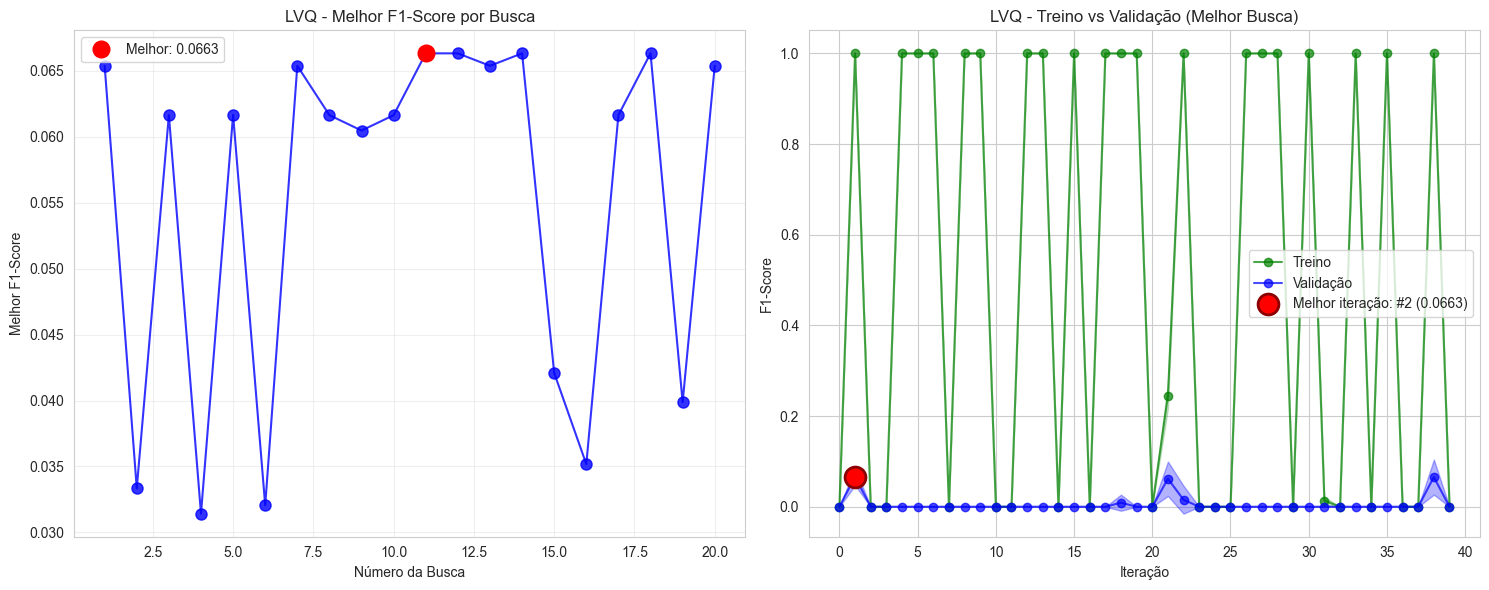

In [42]:
# 4.4 Registro de Desempenho - plotar evolução
# plot_search_history(model_search, MODEL_NAME)
plot_search_history(model_all_searches, model_search, MODEL_NAME)

## 5. Salvar Resultados de Busca
Seção serve somente para salvar o resultado de toda a busca num CSV e os dados essenciais no JSON. 

Usar se quiser manter os resultados guardados num diretório por garantia.

In [43]:
## 4.1 Salvar Resultados da Busca de Hiperparâmetros

print(f"=== SALVANDO RESULTADOS DA BUSCA - {MODEL_NAME} ===")

# Criar pasta se não existir
os.makedirs('searches', exist_ok=True)

# 1. Salvar resultados detalhados de todas as buscas
search_detailed_results = []

for i, search_result in enumerate(model_all_searches):
    # Extrair informações de cada busca individual
    cv_results = search_result['cv_results']
    
    for j in range(len(cv_results['mean_test_score'])):
        search_detailed_results.append({
            'search_idx': search_result['search_idx'],
            'iteration': j,
            'mean_test_score': cv_results['mean_test_score'][j],
            'std_test_score': cv_results['std_test_score'][j],
            'mean_train_score': cv_results['mean_train_score'][j] if 'mean_train_score' in cv_results else None,
            'std_train_score': cv_results['std_train_score'][j] if 'std_train_score' in cv_results else None,
            'params': str(cv_results['params'][j]),
            **cv_results['params'][j]  # Expandir parâmetros como colunas separadas
        })

# Converter para DataFrame e salvar
search_df = pd.DataFrame(search_detailed_results)
search_df.to_csv(f'searches/{MODEL_NAME.lower()}_all_searches.csv', index=False)

print(f"  Todos os Resultados salvos: searches/{MODEL_NAME.lower()}_all_searches.csv")
print(f"  Total de configurações testadas: {len(search_df):,}")

# 2. Salvar resumo da melhor busca
best_search_summary = {
    'model_name': MODEL_NAME,
    'best_overall_score': model_search.best_score_,
    'best_overall_params': model_search.best_params_,
    'search_config': {
        'n_searches': 20,
        'n_iter_per_search': 40,
        'scoring': 'f1',
        'cv_folds': 5,
        'total_configurations': len(search_df)
    },
    'param_space': param_distributions,
    'top_10_configs': search_df.nlargest(10, 'mean_test_score')[
        ['mean_test_score', 'std_test_score'] + list(best_params.keys())
    ].to_dict('records')
}

# Salvar resumo em JSON
with open(f'searches/{MODEL_NAME.lower()}_search_summary.json', 'w') as f:
    json.dump(best_search_summary, f, indent=2)

print(f"  Dados necessários para as seções seguintes: searches/{MODEL_NAME.lower()}_search_summary.json")

# Mostrar estatísticas da busca
print(f"\n--- ESTATÍSTICAS DA BUSCA {MODEL_NAME} ---")
print(f"Melhor F1-Score: {model_search.best_score_:.4f}")
print(f"Desvio padrão do melhor: {search_df.loc[search_df['mean_test_score'].idxmax(), 'std_test_score']:.4f}")
print(f"F1-Score médio geral: {search_df['mean_test_score'].mean():.4f}")
print(f"F1-Score mínimo: {search_df['mean_test_score'].min():.4f}")
print(f"F1-Score máximo: {search_df['mean_test_score'].max():.4f}")


=== SALVANDO RESULTADOS DA BUSCA - LVQ ===
  Todos os Resultados salvos: searches/lvq_all_searches.csv
  Total de configurações testadas: 800


TypeError: Object of type rv_discrete_frozen is not JSON serializable

## 6. Carregar Resultados de Busca
Não precisa rodar caso a busca tenha acabado de ser feita. Rode somente se recuperar resultados salvos.  

In [61]:
import os
import numpy as np
import numpy.ma as ma
import pandas as pd

def parse_params(raw_params):
    """
    Converte strings de best_params para dict Python.

    Funciona para casos como:
    - "{'C': np.float64(156.09), 'gamma': np.float64(0.001)}"
    - "{'criterion': 'entropy', 'max_depth': 33, 'max_features': None, ...}"
    """
    if pd.isna(raw_params):
        return None

    s = str(raw_params)

    # Remove wrappers do numpy: np.float64(...), np.int64(...), etc.
    s = re.sub(r"np\.\w+\((.*?)\)", r"\1", s)

    # Interpreta como literal Python (suporta None, True, False, strings com aspas simples etc.)
    return ast.literal_eval(s)

def parse_cv_results(raw_cv):
    """
    Converte a string de cv_results (repr do scikit) em um dict Python.
    Usa eval com um ambiente controlado.
    """
    env = {
        "array": np.array,
        "masked_array": ma.masked_array,
        "np": np,
        "int32": np.int32,
        "int64": np.int64,
        "float64": np.float64,
        "float32": np.float32,
        "bool_": np.bool_,
    }
    return eval(raw_cv, env)


def load_search_results(model_name, searches_folder='searches'):
    """
    Carrega resultados de busca a partir do CSV e já expande cv_results
    em um DataFrame longo, com uma linha por iteração de cada busca.

    Retorna:
      results['detailed_df'] -> linhas por (search_idx, iteration)
      results['raw_df']      -> CSV original (1 linha por busca)
      results['best_params']
      results['best_score']
      results['summary']     -> compatível com código antigo
    """

    print(f"=== CARREGANDO RESULTADOS DE BUSCA - {model_name.upper()} ===")

    csv_path = os.path.join(searches_folder, f'{model_name.lower()}_all_searches.csv')
    if not os.path.exists(csv_path):
        print(f"❌ Arquivo não encontrado: {csv_path}")
        return None

    raw_df = pd.read_csv(csv_path)
    print(f"📄 CSV carregado com {len(raw_df)} buscas")

    # Se você já tiver parse_params definido, usa aqui
    if "best_params" in raw_df.columns:
        raw_df["parsed_params"] = raw_df["best_params"].apply(parse_params)
    else:
        raw_df["parsed_params"] = None

    # Expandir cv_results em linhas por iteração
    expanded_rows = []

    for _, row in raw_df.iterrows():
        s_idx = int(row["search_idx"])
        cv = parse_cv_results(row["cv_results"])

        mean_test = np.array(cv["mean_test_score"], dtype=float)
        std_test = np.array(cv.get("std_test_score", np.zeros_like(mean_test)), dtype=float)
        mean_train = np.array(cv.get("mean_train_score", np.full_like(mean_test, np.nan)), dtype=float)

        n_iter = len(mean_test)

        for it in range(n_iter):
            expanded_rows.append({
                "search_idx": s_idx,
                "iteration": it,
                "mean_test_score": float(mean_test[it]),
                "std_test_score": float(std_test[it]),
                "mean_train_score": float(mean_train[it]),
            })

    detailed_df = pd.DataFrame(expanded_rows)

    # Melhor resultado por busca (a partir do detalhado)
    best_per_search = detailed_df.loc[detailed_df.groupby("search_idx")["mean_test_score"].idxmax()]
    best_per_search = best_per_search.sort_values("search_idx").reset_index(drop=True)

    best_overall_row = best_per_search.loc[best_per_search["mean_test_score"].idxmax()]
    best_overall_score = float(best_overall_row["mean_test_score"])

    # Melhor linha no CSV original para pegar params
    raw_best_idx = raw_df["best_score"].idxmax()
    best_params = raw_df.loc[raw_best_idx, "parsed_params"]

    print(f"🏆 Melhor busca geral: search_idx = {int(best_overall_row['search_idx'])}, score = {best_overall_score:.4f}")
    print(f"   Parâmetros: {best_params}")

    results = {
        "raw_df": raw_df,
        "detailed_df": detailed_df,
        "best_params": best_params,
        "best_score": best_overall_score,
        "summary": {
            "best_overall_params": best_params,
            "best_overall_score": best_overall_score,
        },
    }

    return results



def get_best_params_from_saved(model_name, searches_folder='searches'):
    """
    Recupera os melhores parâmetros de arquivos salvos
    
    Returns:
    --------
    dict: Melhores parâmetros encontrados
    """
    # Tentar carregar do JSON primeiro
    json_path = os.path.join(searches_folder, f'{model_name.lower()}_search_summary.json')
    
    if os.path.exists(json_path):
        with open(json_path, 'r') as f:
            summary = json.load(f)
        return summary['best_overall_params']
    
    # Fallback para pickle
    pkl_path = os.path.join(searches_folder, f'{model_name.lower()}_full_search.pkl')
    if os.path.exists(pkl_path):
        with open(pkl_path, 'rb') as f:
            backup = pickle.load(f)
        return backup['best_params']
    
    print(f"❌ Não foi possível carregar parâmetros para {model_name}")
    return None


In [62]:
#### 4.2 Carregar Resultados Salvos (Função Auxiliar)
# Exemplo de uso da função (não executar se já temos os resultados)
loaded_results = load_search_results(MODEL_NAME)

=== CARREGANDO RESULTADOS DE BUSCA - DT ===
📄 CSV carregado com 20 buscas
🏆 Melhor busca geral: search_idx = 8, score = 0.1104
   Parâmetros: {'criterion': 'entropy', 'max_depth': 38, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 14}


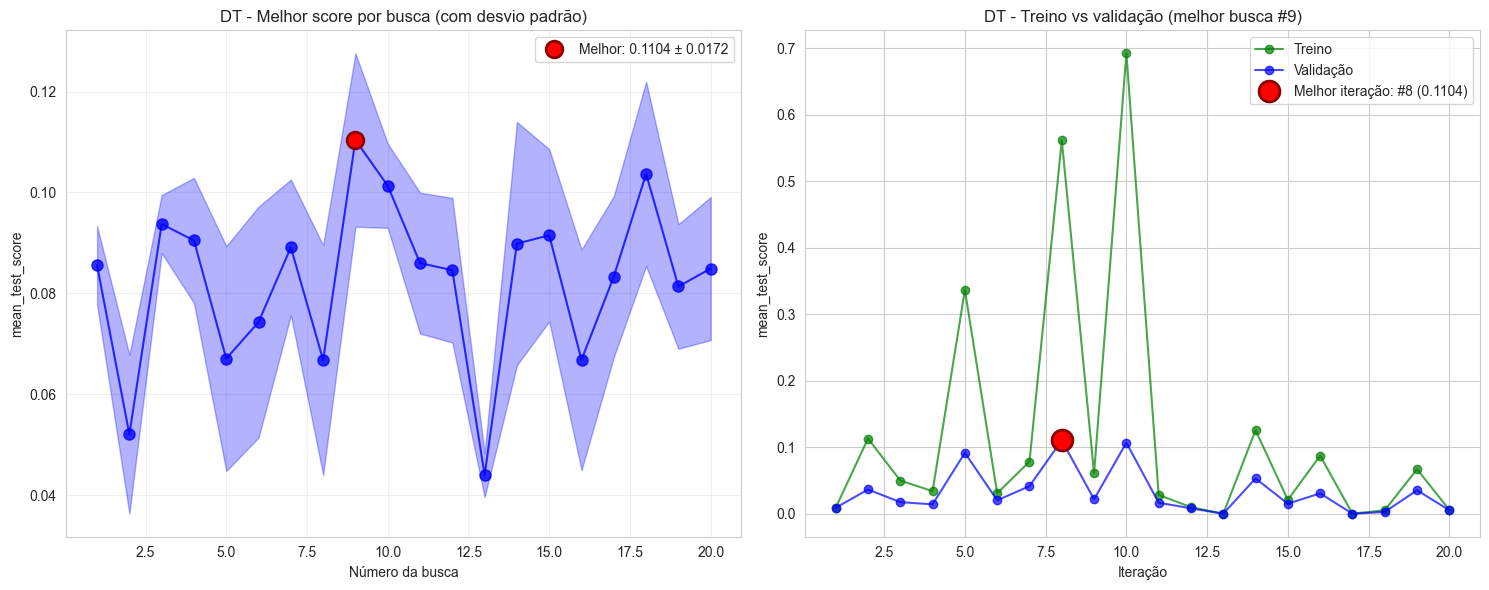

In [63]:
# Plotar a história da busca a partir dos resultados carregados
plot_search_history_from_loaded(loaded_results, MODEL_NAME)

In [ ]:

#### 4.3 Recuperar Melhores Parâmetros para Uso Posterior
# Exemplo de uso (descomente se precisar carregar parâmetros salvos):
if 'loaded_results' in locals():
    best_params = get_best_params_from_saved(MODEL_NAME)
    if best_params:
        print(f"✅ Parâmetros carregados: {best_params}")
    best_score = loaded_results['summary']['best_overall_score']
    print(f"✅ Melhor F1-Score carregado: {best_score:.4f}")
else:
    best_params = model_search.best_params_
    best_score = model_search.best_score_
    print(f"✅ Usando parâmetros da busca atual: {best_params}")
    print(f"✅ Melhor F1-Score da busca atual: {best_score:.4f}")

## 7. Train Final Model and Save It as Joblib

In [ ]:
# 5.2 Treinamento Final com dataset completo usando melhores hiperparâmetros


best_model = KNeighborsClassifier(**model_search.best_params_) 

# Armazenar resultados

model_results = {
    'model': best_model,
    'search': model_search,
    'best_params': model_search.best_params_,
    'best_cv_score': model_search.best_score_
}

In [ ]:
# =============================================
# Descomentar linhas abaixo para treinar com amostra menor estratificada do dataset completo
# =============================================
# _, X_sample2, _, y_sample2 = train_test_split(
#     X_train_scaled, y_train, 
#     test_size=0.5,  
#     stratify=y_train
#     random_state=10
# )
# X_train_scaled, y_train = X_sample2, y_sample2

best_model.fit(X_train_scaled, y_train)  # Treino 
print(f"\nModelo final {MODEL_NAME} treinado com dataset completo: {best_model}")

In [ ]:
# Salvar modelo treinado

# Criar pasta se não existir
os.makedirs('models', exist_ok=True)

dump(best_model, f'models/{MODEL_NAME.lower()}_trained.joblib')

## 8. Load Model, Eval and Save Metrics

### 8.1 Load libs and Model

In [ ]:
# Carregar modelo
loaded_model = load(f'models/{MODEL_NAME.lower()}_trained.joblib')

### 8.2 Eval

In [ ]:
print(f"=== AVALIAÇÃO E SALVAMENTO DOS RESULTADOS - {MODEL_NAME} ===")

# Criar pasta se não existir
os.makedirs('results', exist_ok=True)

# 2. Avaliação completa do modelo (usando amostras para economizar tempo)
print("\nAvaliando performance do modelo...")

try:
    model = best_model
except NameError:
    model = loaded_model


X_train_eval = X_train_scaled
y_train_eval = y_train
X_test_eval = X_test_scaled
y_test_eval = y_test

# ===========================================
# Usar amostras do dataset se necessário (descomentar linhas abaixo)
# ===========================================
# _, X_test_eval, _, y_test_eval = train_test_split(
# X_test_eval, y_test_eval,
# test_size=0.3, 
# stratify=y_test_eval,
# random_state=42
# )

# _, X_train_eval, _, y_train_eval = train_test_split(
# X_train_eval, y_train_eval,
# test_size=0.1, 
# stratify=y_train_eval,
# random_state=42
# )


# Avaliar modelo
train_metrics, test_metrics, y_pred = evaluate_model(
    model, X_train_eval, X_test_eval, y_train_eval, y_test_eval, MODEL_NAME
)

In [ ]:
# 3. Compilar todos os resultados
model_final_results = {
    'model_name': MODEL_NAME,
    'best_params': model_search.best_params_,
    'best_cv_score': model_search.best_score_,
    'train_metrics': train_metrics,
    'test_metrics': test_metrics,
    'predictions': y_pred.tolist(), # Converter para lista no JSON
    'test_labels': y_test_eval.tolist(),
    'evaluation_info': {
        'train_samples_used': len(X_train_eval),
        'test_samples_used': len(X_test_eval),
        'total_train_samples': len(X_train_scaled),
        'total_test_samples': len(X_test_scaled)
    }
}

### 8.3 Save Results for Plot

In [ ]:
with open(f'results/{MODEL_NAME.lower()}_results.json', 'w') as f:
    json.dump(model_final_results, f, indent=2)

print(f"Resultados {MODEL_NAME} salvos em: results/{MODEL_NAME.lower()}_results.json")

In [ ]:
# ================
# Rode se quiser salvar um backup em pickle também ou caso anterior JSON falhe
# ================

with open(f'results/{MODEL_NAME.lower()}_results.pkl', 'wb') as f:
    pickle.dump(model_final_results, f)

print(f"Backup dos resultados salvo em: results/{MODEL_NAME.lower()}_results.pkl")

# Mostrar resumo para verificação rápida
print(f"\n--- RESUMO {MODEL_NAME} ---")
print(f"F1-Score CV: {model_final_results['best_cv_score']:.4f}")
print(f"F1-Score Teste: {test_metrics['f1']:.4f}")
print(f"Precisão Teste: {test_metrics['precision']:.4f}")
print(f"Recall Teste: {test_metrics['recall']:.4f}")
print(f"G-Mean Teste: {test_metrics['gmean']:.4f}")